In [1]:
import random
from os import path

import numpy as np
import torch
import torchvision.transforms as transforms
from torchsummary import summary

import dataloaders
import networks.utils as utils
import networks.wdcgan_gp as wdcgan

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda'  #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREADS = torch.get_num_threads()
    print("Number of Threads: ", NUM_THREADS)
else:
    NUM_THREADS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threads:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data", "tmdb-64")
TABLE_PATH = path.join("data", "tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3  # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
BASE_NUM_OUT_CHANNELS_G = 64
BASE_NUM_OUT_CHANNELS_D = 64
D_NORM_LAYER_TYPE = "instance"  # "none", "spectral", "instance", "layer"
PADDING_MODE = "reflect"
COLORMODE = "RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
BETA1 = 0.5  #default 0.
BETA2 = 0.999  #default 0.9
N_CRITIC = 5  #default 5
LAMBDA_GP = 10  #default 10

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs", "wdcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 1
SAVE_FAKES_EVERY_N_EPOCHS = 1

#MODEL_TO_LOAD = path.join(OUT_PATH, "2022-09-25_17-15-49/gan_at_epoch_0001.pt")
MODEL_TO_LOAD = None

### Load dataset

In [5]:
# Poster subset:
GENRE = None
GENRE_LOGIC = 'and'
OG_LANG = None
YEAR = None
RUNTIME = (40, np.inf)
MAX_NUM = None
SORT = None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                           img_transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                           colormode=COLORMODE,
                                           img_in_ram=False,
                                           genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR,
                                           runtime=RUNTIME,
                                           max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_THREADS,
                                           pin_memory=True)

Sample dataset:

The dataset has 224094 entries.


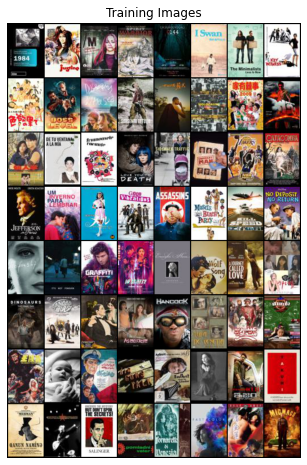

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

### Initialize Network

In [7]:
generator, discriminator = wdcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS,
                                             num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                             base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G,
                                             base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D,
                                             d_norm_layer_type=D_NORM_LAYER_TYPE, padding_mode=PADDING_MODE,
                                             device=device)

print("Generator:")
summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, 1, 1))
print("\nDiscriminator:")
summary(discriminator, input_size=(3, 96, 64))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14        

In [8]:
trainer = wdcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE,
                                num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO,
                                d_params=discriminator.parameters(), g_params=generator.parameters(),
                                learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, n_critic=N_CRITIC,
                                lambda_gp=LAMBDA_GP, device=device)

## Train

[0/9]	Loss_D: 1.4350	Loss_G: -0.7878	D(x): 2.9239	D(G(z)): 3.9033 / 0.7878: 100%|██████████| 3502/3502 [08:04<00:00,  7.23it/s]        


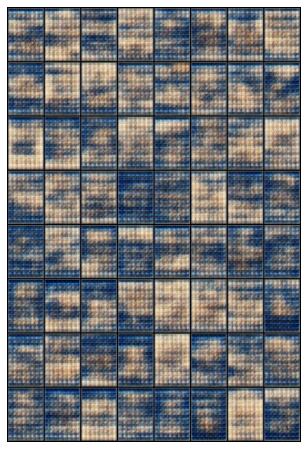

[1/9]	Loss_D: -6.9518	Loss_G: 10.0925	D(x): 0.7110	D(G(z)): -7.8068 / -10.0925: 100%|██████████| 3502/3502 [08:36<00:00,  6.78it/s]   


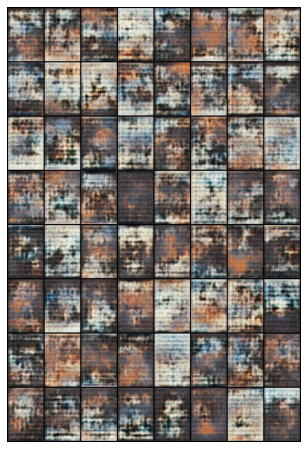

[2/9]	Loss_D: -13.1162	Loss_G: 13.5067	D(x): 3.8278	D(G(z)): -12.4196 / -13.5067: 100%|██████████| 3502/3502 [08:39<00:00,  6.74it/s] 


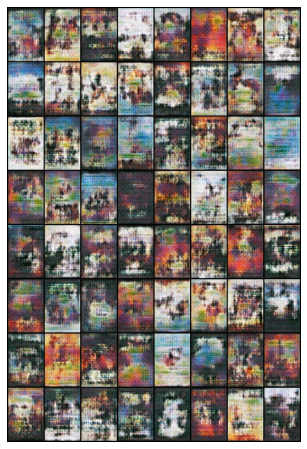

[3/9]	Loss_D: -11.1083	Loss_G: 14.5605	D(x): 4.1322	D(G(z)): -14.3995 / -14.5605: 100%|██████████| 3502/3502 [08:26<00:00,  6.91it/s] 


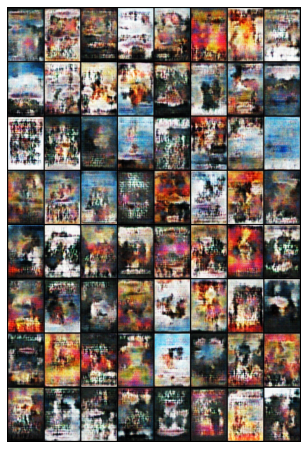

[4/9]	Loss_D: -15.7026	Loss_G: 16.9660	D(x): 3.9855	D(G(z)): -14.5842 / -16.9660: 100%|██████████| 3502/3502 [08:27<00:00,  6.90it/s] 


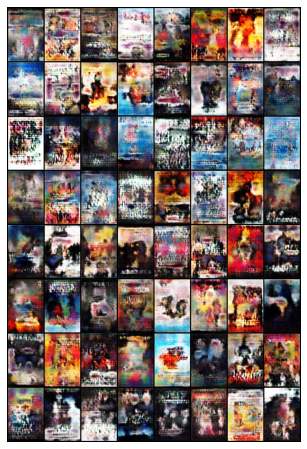

[5/9]	Loss_D: -17.5137	Loss_G: 21.7790	D(x): 0.5512	D(G(z)): -20.5178 / -21.7790: 100%|██████████| 3502/3502 [08:33<00:00,  6.83it/s] 


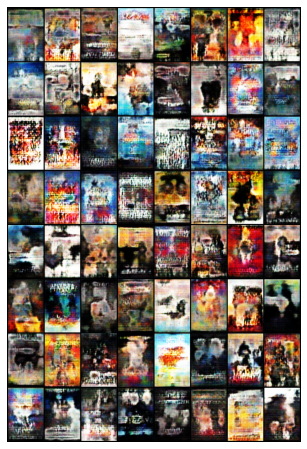

[6/9]	Loss_D: -10.0315	Loss_G: 18.1726	D(x): -3.4502	D(G(z)): -18.1246 / -18.1726: 100%|██████████| 3502/3502 [08:26<00:00,  6.91it/s]


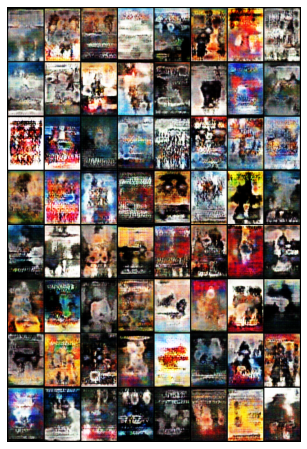

[7/9]	Loss_D: -17.1289	Loss_G: 21.9257	D(x): -1.3277	D(G(z)): -22.5039 / -21.9257: 100%|██████████| 3502/3502 [08:14<00:00,  7.09it/s] 


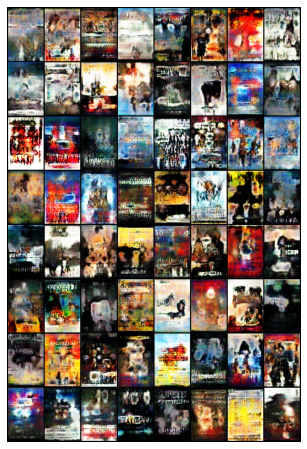

[8/9]	Loss_D: -14.7712	Loss_G: 26.3647	D(x): -4.5395	D(G(z)): -29.2484 / -26.3647: 100%|██████████| 3502/3502 [08:36<00:00,  6.78it/s] 


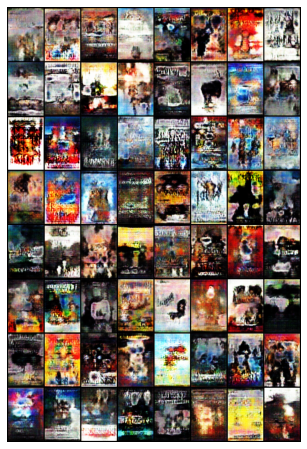

[9/9]	Loss_D: -13.9514	Loss_G: 27.1734	D(x): -9.8014	D(G(z)): -30.2519 / -27.1734: 100%|██████████| 3502/3502 [08:21<00:00,  6.98it/s] 


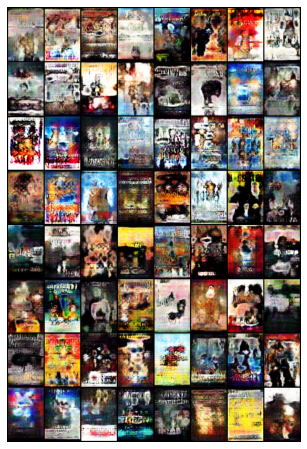

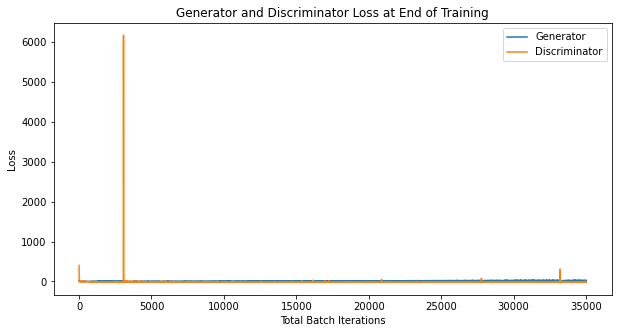

In [9]:
SHOW_GRAPHS = True

trainer.train(generator, discriminator, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device,
              fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS, model_snap=SAVE_MODEL_EVERY_N_EPOCHS,
              model_to_load=MODEL_TO_LOAD, show_graphs=SHOW_GRAPHS)

### Show results

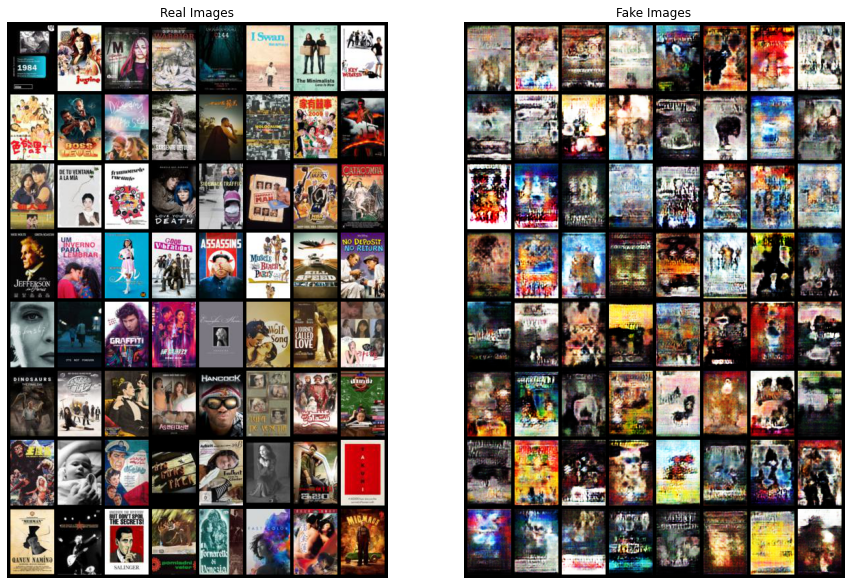

In [10]:
utils.plot_reals_vs_fakes(generator, trainer, sample_reals, NUM_SAMPLES,
                          path.join(trainer.last_out_dir, "real_vs_fake.png"), device)